In [1]:
%reload_ext magic.write_eval

In [2]:
%%write_eval imports.py
import os
from collections import namedtuple
from io import StringIO
import re

import requests

import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

import jax
from jax.experimental.ode import odeint, vjp_odeint
import jax.numpy as np
from jax.random import PRNGKey
import numpy as onp

import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS, Predictive
import arviz as az

NUM_CHAINS = 1
numpyro.set_host_device_count(NUM_CHAINS)
numpyro.enable_x64()

plt.style.use('ggplot')

Overwriting imports.py


# Data

In [3]:
# %load fetching.py

# country codes
def fetch_isocodes():
    isocodes = pd.read_csv('../input/countries-iso-codes/wikipedia-iso-country-codes.csv')
    isocodes.columns = isocodes.columns.str.replace(' ', '_').str.lower()
    isocodes = isocodes.rename({"english_short_name_lower_case": 'country_name'}, axis=1)
    return isocodes

# ACAPS
def fetch_acaps(isocodes, url=None):
    if url is not None:
        measures = pd.read_excel(url, sheet_name='Database')
        measures.to_csv('acaps.csv', index=False)
    
    measures = pd.read_csv('acaps.csv')
    measures.columns = measures.columns.str.lower()
    measures['date_implemented'] = pd.to_datetime(measures['date_implemented'])

    measures = measures.merge(isocodes, left_on='iso', right_on='alpha-3_code')
    return measures

# ECDC for names of lactions
def fetch_ecdc():
    ecdc = (pd.read_csv('https://covid.ourworldindata.org/data/owid-covid-data.csv')
            .assign(date=lambda f: f['date'].pipe(pd.to_datetime))
           )
    
    return ecdc

# Apple mobility

def fetch_apple(location_code, url=None):
    if url is not None:
        response = requests.get(url)
        apple_mobility = (pd.read_csv(StringIO(response.content.decode())))
        apple_mobility.to_csv('apple.csv', index=False)

    apple_mobility = (pd.read_csv('../input/apple-covid-mobility/applemobilitytrends.csv')
                      .drop('alternative_name', axis=1)
                      .set_index(['geo_type', 'region', 'transportation_type'])
                      .rename_axis("date", axis=1)
                      .stack()
                      .rename('change')
                      .reset_index('date')
                      .assign(date=lambda f: pd.to_datetime(f['date']))
                      .set_index('date', append=True)
                      )

    apple_mobility = (apple_mobility
                      .reset_index()
                      .replace({'UK': 'United Kingdom', 'Republic of Korea': 'South Korea', 'Macao': 'Macau'})  # Only missing is Macao
                      .merge(location_code, left_on='region', right_on='location', how='left')
                     .assign(change=lambda f: f['change'].div(100).sub(1)))

    apple_mobility = apple_mobility.loc[lambda f: f['iso_code'].notna()].set_index(['iso_code', 'date', 'transportation_type'])['change'].unstack()
    return apple_mobility

def fetch_google(isocodes, location_code):
    google_mobility = pd.read_csv('https://www.gstatic.com/covid19/mobility/Global_Mobility_Report.csv', parse_dates=['date'])

    def safe_match(pat, text):
        match = re.match(pat, text)
        return match.groups()[0] if match else text

    google_mobility.columns = google_mobility.columns.map(lambda col: safe_match("(.*)_percent", col))
    google_mobility = (google_mobility
                .merge(isocodes, left_on='country_region_code', right_on='alpha-2_code', how='left')
                .merge(location_code, left_on='alpha-3_code', right_on='iso_code', how='left'))

    google_mobility = google_mobility.loc[lambda f: f['sub_region_1'].isna()].set_index(['iso_code', 'date']).select_dtypes(float).div(100)
    return google_mobility

# oxford.columns[mask].str.extract(r'(..)_.*', expand=False)

def fetch_oxford():
    oxford = pd.read_csv('https://github.com/OxCGRT/covid-policy-tracker/raw/master/data/OxCGRT_latest.csv')
    oxford.columns = oxford.columns.map(str.lower).str.replace(' ', '_')
    oxford['date'] = pd.to_datetime(oxford['date'], format='%Y%m%d')

    ordinal_columns = oxford.columns[oxford.columns.str.contains("^c._.*_.*")]
    geographic_columns = oxford.columns[oxford.columns.str.contains('^c._flag')]
    strip_measure_name = lambda name: name.split('_')[0]
    measures_ix = dict(zip(ordinal_columns.map(strip_measure_name), ordinal_columns.map(lambda s: '_'.join(s.split('_')[1:]))))

    oxford_long = (oxford
                   .set_index(['countrycode', 'date'])
                   [geographic_columns]
                   .rename(columns=strip_measure_name)
                   .rename_axis('category', axis=1)
                   .stack()
                   .to_frame('flag')
                   .join(oxford.set_index(['countrycode', 'date'])
                         [ordinal_columns]
                         .rename(columns=strip_measure_name)
                         .replace(0, np.nan)
                         .rename_axis('category', axis=1)
                         .stack()
                         .rename('measure'),
                         how='outer'
                        )
                  )

    oxford_long = (oxford_long
                   .rename_axis('variable', axis=1)
                   .stack()
                   .rename('value'))
    return oxford_long

In [4]:
isocodes = fetch_isocodes()
# acaps = fetch_acaps(isocodes)
ecdc = fetch_ecdc().set_index(['iso_code', 'date'])
location_code = ecdc.groupby(['location', 'iso_code']).first().iloc[:, 0].reset_index().iloc[:,:2]
apple = fetch_apple(location_code)
google = fetch_google(isocodes, location_code)
mobility = google.join(apple, how='outer')
populations_country = (ecdc.assign(population = lambda f: 
                                   f['new_cases']
                                   .div(f['new_cases_per_million'])
                                   .mul(1_000_000))
                       .groupby('iso_code')
                       ['population']
                       .last())

country_code_lookup = ecdc.reset_index()[['iso_code', 'location']].drop_duplicates().set_index('location').iloc[:, 0]
country_name_lookup = country_code_lookup.reset_index().set_index('iso_code').iloc[:, 0]

/home/horace/miniconda3/envs/uncoverun/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3254: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


In [5]:
%%write_eval model/preprocessing.py
import pandas as pd

ix = pd.IndexSlice

mobility_categories = [
    'grocery_and_pharmacy',
#         'transit', 'walking', 'driving', 
    'retail_and_recreation', 'workplaces', 'transit_stations']

def diff_pop(cumulative, pop_country):
    daily = np.hstack((np.array([0.]), np.diff(cumulative * pop_country)))
    daily += 1
    return daily

def make_dataset(mobility, ecdc, days_before_deaths):
    deaths_subset = ecdc['total_deaths']
    
    ten_deaths_date = deaths_subset.gt(10).idxmax()
    begin_date = ten_deaths_date - pd.Timedelta(days_before_deaths, unit='days')

    total_deaths = deaths_subset.loc[begin_date:].to_numpy()
    times = deaths_subset.loc[begin_date:].index.map(onp.datetime64).to_numpy()

    mobility_subset = mobility[mobility_categories]

    mobility_subset = (mobility_subset
                .reindex(deaths_subset.loc[begin_date:].index)
                .fillna(method='ffill')
                .fillna(method='bfill')
                #.fillna(mobility.iloc[-1])
                .rolling('7d').mean())
    
    mobility_data = np.asarray(mobility_subset.to_numpy())
    return total_deaths, times, mobility_data

def make_all_datasets(mobility, ecdc, populations_country, country_names, days_before_deaths):
    all_countries = []
    all_populations = []
    all_mobilities = []
    all_deaths = []
    all_times = []
    for country, subset in ecdc.groupby('iso_code'):
        if country not in country_names:
            continue
        subset = subset.reset_index('iso_code', drop=True)
        all_countries.append(country)
#         try:
        total_deaths, times, mobility_data = make_dataset(mobility.loc[country], subset, days_before_deaths)
#         except KeyError:
#             continue
        pop_country = populations_country.loc[country]
        daily_deaths = diff_pop(total_deaths / pop_country, pop_country)
        all_populations.append(pop_country)
        all_mobilities.append(mobility_data)
        all_deaths.append(daily_deaths)
        all_times.append(times)
    return all_countries, all_populations, all_mobilities, all_deaths, all_times

Overwriting model/preprocessing.py


In [6]:
SELECTED_COUNTRIES = [country_code_lookup.loc[name] 
                      for name in 
                      ('Denmark', 'Sweden', 'France', 'Germany', 'United Kingdom', 
                       'Spain', 'Italy'
                      )
                     ]

NB_DAYS_BEFORE_TEN_DEATHS = 30

all_countries, all_populations, all_mobilities, all_deaths, all_times = make_all_datasets(mobility,
                                                                                          ecdc,
                                                                                          populations_country, 
                                                                                          SELECTED_COUNTRIES, 
                                                                                          NB_DAYS_BEFORE_TEN_DEATHS)

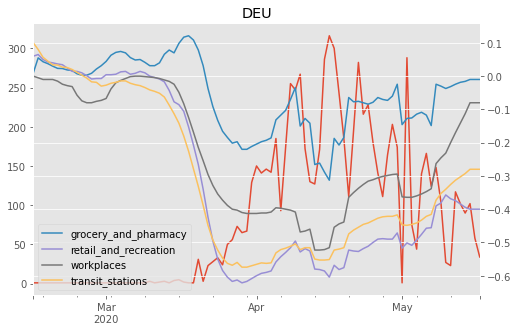

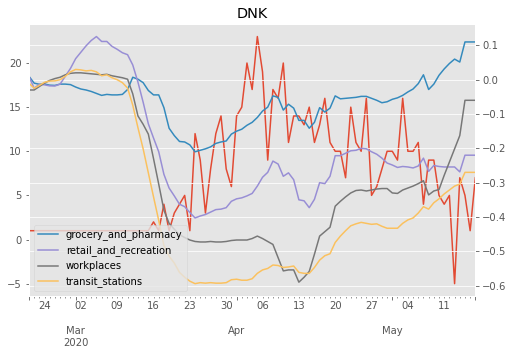

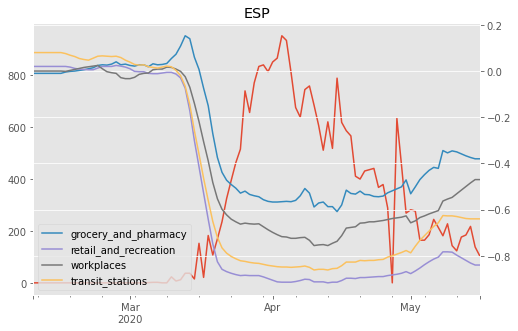

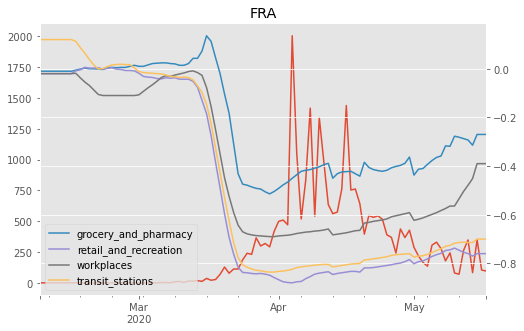

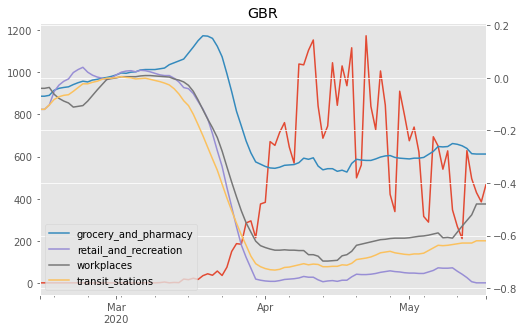

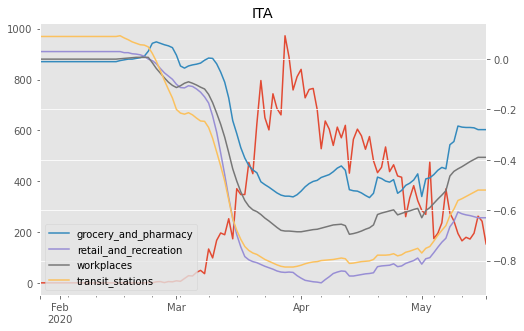

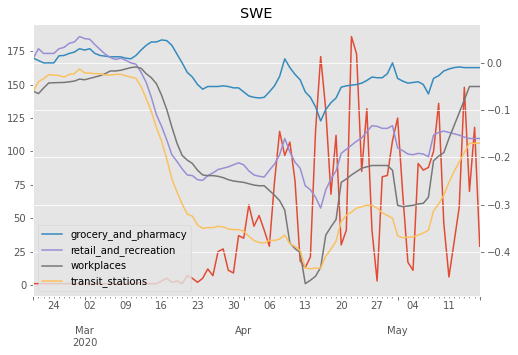

In [7]:
for i, country in enumerate(all_countries):
    pop = all_populations[i]
    mobility_data = all_mobilities[i]
    total_deaths = all_deaths[i]
    times = all_times[i]
    ax = pd.DataFrame(total_deaths).set_index(times).plot(legend=False, figsize=(8, 5))
    pd.DataFrame(mobility_data, columns=mobility_categories).set_index(times).plot(ax=ax, secondary_y=True, legend=False)
    plt.title(country)
    plt.legend(loc='lower left')

# Model

https://www.kaggle.com/anjum48/seir-hcd-model

## Prior choice

We use France's Covid data, that includes the number of critical, deceased, hospitalized (and recovered).

In [8]:
%%write_eval prior_means.py
from collections import namedtuple

Params = namedtuple('Params', 
                    ['r0', 'r1', 
                     't_inc', 't_inf', 't_hosp', 't_crit', 
                     'm_a', 'c_a', 'f_a']
                   )

# PRIOR_MEANS = Params(
#     r0=3.3,
#     r1=0.5, 
#     t_inc=5.1, 
#     t_inf=2.79, 
#     t_hosp=5.14, 
#     t_crit=5., 
#     m_a=0.85, 
#     c_a=0.2, 
#     f_a=0.33)

PRIOR_MEANS = Params(
    r0=3.28,
    r1=0.2, 
    t_inc=5.6, 
    t_inf=7.9, 
    t_hosp=4., 
    t_crit=14., 
    m_a=0.8, 
    c_a=0.1, 
    f_a=0.35)


Overwriting prior_means.py


## SEIR-HCD model

In [9]:
%%write_eval ode.py
def build_my_odeint(mobility_data, rtol=1e-5, atol=1e-9, mxstep=500):
    """
    code based on jax.experimental.ode.build_ode to make it work with mobility data
    """
    def dz_dt(z, t, r0, r1, t_inc, t_inf, t_hosp, t_crit, m_a, c_a, f_a, *alpha):
        s = z[0]
        e = z[1]
        i = z[2]
        r = z[3]
        h = z[4]
        c = z[5]
        
        alpha_ = np.array(alpha)
        int_t = np.array([t]).astype(int)[0]
        rt_u = r0 * (1 + mobility_data[int_t]) - r1 * mobility_data[int_t]
        rt = np.dot(rt_u, alpha_)
#         rt = alpha0 * rt_u[0] + alpha1 * rt_u[1]
        
        ds = - (rt / t_inf) * i * s
        de = (rt / t_inf) * i * s - (e / t_inc)
        di = e / t_inc - i / t_inf
        dr = m_a * i / t_inf + (1 - c_a) * (h / t_hosp)
        dh = (1 - m_a) * (i / t_inf) + (1 - f_a) * c / t_crit - h / t_hosp
        dc = c_a * h / t_hosp - c / t_crit
        dd = f_a * c / t_crit

        return np.stack([ds, de, di, dr, dh, dc, dd])

    ct_odeint = jax.custom_transforms(
        lambda y0, t, *args: odeint(dz_dt, y0, t, *args, rtol=rtol, atol=atol, mxstep=mxstep))

    v = lambda y0, t, *args: vjp_odeint(dz_dt, y0, t, *args, rtol=rtol, atol=atol, mxstep=mxstep)

    jax.defvjp_all(ct_odeint, v)

    return jax.jit(ct_odeint)

Overwriting ode.py


## Bayesian model

In [10]:
%%write_eval reparameterizations.py

def reparametrize_beta(mean, sample_size):
#     v = numpyro.sample(f'sample_size_{i}', dist.Gamma(*reparametrize_gamma(10., 5)))
    alpha = mean * sample_size
    beta = (1 - mean) * sample_size
    return alpha, beta 

def reparametrize_gamma(mean, std):
    var = std ** 2
    alpha = mean ** 2 / var
    beta = mean / var
    return alpha, beta

Overwriting reparameterizations.py


In [45]:
%%write_eval model.py

def make_target_dist(psi_h, psi_c, psi, 
                     daily_hosp, daily_critical, daily_deaths, 
                     bump_hosp, bump_critical, N):
    
    target_dist = dist.GammaPoisson(
                   np.array([psi_h, psi_c, psi]),
                   rate=np.stack([psi_h / (daily_hosp + bump_hosp), 
                                  psi_c / (daily_critical + bump_critical), 
                                  psi / daily_deaths]
                                ).T
    )

    reloc = dist.transforms.AffineTransform(
        loc=np.stack([
            - bump_hosp,
            - bump_critical,
            np.zeros(N)]
        ).T,
        scale=1.)

    reloc_target_dist = dist.TransformedDistribution(target_dist, [reloc])
    return reloc_target_dist

def sample_parameters(nb_mobilities):
    kappa0 = numpyro.sample('kappa0', dist.TruncatedNormal(0, 0., 0.5))
    kappa1 = numpyro.sample('kappa1', dist.TruncatedNormal(0, 0, 0.5))
    r0 = numpyro.sample('r0', dist.TruncatedNormal(0, PRIOR_MEANS.r0, kappa0))
    r1 = numpyro.sample('r1', dist.TruncatedNormal(0, PRIOR_MEANS.r1, kappa1))

    alpha = numpyro.sample('alpha', dist.Gamma(*reparametrize_gamma(1., 0.5)), sample_shape=(nb_mobilities,))
    alpha /= np.sum(alpha)
    
    t_inc = numpyro.sample('t_inc', dist.Gamma(*reparametrize_gamma(PRIOR_MEANS.t_inc, .86)))
    t_inf = numpyro.sample('t_inf', dist.Gamma(*reparametrize_gamma(PRIOR_MEANS.t_inf, 3.)))
    t_hosp = numpyro.sample('t_hosp', dist.Gamma(*reparametrize_gamma(PRIOR_MEANS.t_hosp, 3.)))
    t_crit = numpyro.sample('t_crit', dist.Gamma(*reparametrize_gamma(PRIOR_MEANS.t_crit, 3.)))
    
    sample_size_m = numpyro.sample('sample_size_m', dist.Gamma(*reparametrize_gamma(7., 2)))
    sample_size_c = numpyro.sample('sample_size_c', dist.Gamma(*reparametrize_gamma(7., 2)))
    sample_size_f = numpyro.sample('sample_size_f', dist.Gamma(*reparametrize_gamma(7., 2)))
    m_a = numpyro.sample('m_a', dist.Beta(*reparametrize_beta(PRIOR_MEANS.m_a, sample_size_m)))
#     m_a = 0.8
    c_a = numpyro.sample('c_a', dist.Beta(*reparametrize_beta(PRIOR_MEANS.c_a, sample_size_c)))
    f_a = numpyro.sample('f_a', dist.Beta(*reparametrize_beta(PRIOR_MEANS.f_a, sample_size_f)))
    
    params = (r0, r1, t_inc, t_inf, t_hosp, t_crit, m_a, c_a, f_a)
    
    return params, alpha
    

def sample_compartment_init(pop_country, country_name=None):
#     tau = numpyro.sample('tau', dist.Exponential(0.03))
#     kappa_i0 = numpyro.sample('kappa_i0', dist.TruncatedNormal(0, 0., 0.5))
    i_init = numpyro.sample(f'i_init_{country_name}', 
                            dist.TruncatedNormal(loc=50., scale=10.)
#                             dist.Gamma(*reparametrize_gamma(50, 10.))
#                             dist.Exponential(1. / tau)
                           )
    i_init /= pop_country
    z_init = np.array([1. - i_init, 0., i_init, 0., 0., 0., 0.])
    return z_init
    
def model(seirhcd_int, N, pop_country, y=None, compartments='d', nb_mobilities=1):
    ts = np.arange(float(N))
    params, alpha = sample_parameters(nb_mobilities=nb_mobilities)
    z_init = sample_compartment_init(pop_country)
    
    z = seirhcd_int(z_init, ts, *params, *alpha)
    
    daily_deaths = diff_pop(z[:, -1], pop_country)
    psi = numpyro.sample('psi', dist.TruncatedNormal(scale=5.))

    if compartments == 'd':
        numpyro.sample('deceased', dist.GammaPoisson(psi, rate=psi / daily_deaths), obs=y)

    elif compartments == 'hcd':
        daily_hosp = diff_pop(z[:, -3], pop_country)
        daily_critical = diff_pop(z[:, -2], pop_country)

        hosp = z[:, -3] * pop_country
        critical = z[:, -2] * pop_country

        hosp_m1 = np.hstack(([0.],  hosp[:-1]))
        critical_m1 = np.hstack(([0.],  critical[:-1]))

        bump_hosp = np.min(np.stack([hosp_m1, BUMP_HOSP * np.ones(N)]), axis=0)
        bump_critical = np.min(np.stack([critical_m1, BUMP_CRITICAL * np.ones(N)]), axis=0)

        psi_h = numpyro.sample('psi_h', dist.TruncatedNormal(scale=5.))
        psi_c = numpyro.sample('psi_c', dist.TruncatedNormal(scale=5.))
        
        target_dist = make_target_dist(psi_h, psi_c, psi, 
                                       daily_hosp, daily_critical, daily_deaths, 
                                       bump_hosp, bump_critical, N)
        
        numpyro.sample('y', target_dist, obs=y)


def multi_model(all_mobilities, all_populations, observations=None):
    nb_mobilities = all_mobilities[0].shape[1]
    params, alpha = sample_parameters(nb_mobilities=nb_mobilities)
    psi = numpyro.sample('psi', dist.TruncatedNormal(scale=5.))
    i_init = numpyro.sample('i_init', dist.TruncatedNormal(loc=50, scale=10))
    if observations is None:
        observations = [None]*len(all_mobilities)
    for country in range(len(all_mobilities)):
        mobility_data = all_mobilities[country]
        pop_country = all_populations[country]
        seirhcd_int = build_my_odeint(mobility_data, 
#                                       atol= 1. / pop_country
                                     )
        y = observations[country]
        ts = np.arange(float(mobility_data.shape[0]))

        z_init = np.array([1. - i_init / pop_country, 0., i_init / pop_country, 0., 0., 0., 0.])
        z = seirhcd_int(z_init, ts, *params, *alpha)

        daily_deaths = diff_pop(z[:, -1], pop_country)

        numpyro.sample(f'deceased_{country}', dist.GammaPoisson(psi, rate=psi / daily_deaths), obs=y)
    
#     vmap(sample_deceased)(np.arange(0, len(all_mobilities), step=1, dtype=int))
#     jax.lax.fori_loop(0, len(all_mobilities), lambda i, val: sample_deceased(i), 0)


Overwriting model.py


## Result visualization

In [46]:
%%write_eval postprocess.py

def compute_mu_pi_2(y_pred):
    pop_pred = np.stack([y_pred['hosp'], y_pred['critical'], y_pred['deceased']]).T
    mu = np.mean(pop_pred, 1)
    pi = np.percentile(pop_pred.astype(float), (10., 90.), 1)
    return mu, pi

def compute_mu_pi(y_pred, observation_name='y'):
    pop_pred = y_pred[observation_name]
    mu = np.mean(pop_pred, 0)
    pi = np.percentile(pop_pred.astype(float), (10., 90.), 0)
    return mu, pi

def plot_compartment_results(mu, y_true, times, pi=None):
    plt.plot(times, y_true, "bx", label="true")
    plt.plot(times, mu, "b--", label="pred")
    if pi is not None:
        plt.fill_between(times, pi[0, :], pi[1, :], color="b", alpha=0.3)
    plt.legend()
    plt.xticks(rotation=45)

    plt.tight_layout()
    plt.title('Daily deaths')

def plot_daily_cumulated(mu, pi, data, times, name):
    fig, ax = plt.subplots(figsize=(8, 5))
    plot_compartment_results(mu, data, times, pi)
    plt.title('Daily ' + name)

    fig, ax = plt.subplots(figsize=(8, 5))
    plot_compartment_results(np.cumsum(mu), np.cumsum(data), times)
    plt.title('Cumulated ' + name)

# # Control for HCD params
def plot_hcd_results(mu, pi, data, times):
    for i, name in enumerate(['deaths', 'critical', 'hospitalized'], start=1):
        plot_daily_cumulated(mu[:, -i], pi[:, :, -i], data[:, -i], times, name)
        
def plot_forest(inference_data):
    az.plot_forest(inference_data, var_names=['t_inc', 't_inf', 't_hosp', 't_crit'], 
                   kind='forestplot', ridgeplot_overlap=3, combined=True, figsize=(9, 3))
    plt.grid()
    az.plot_forest(inference_data, var_names=['m_a', 'c_a', 'f_a'], figsize=(9, 2))
    plt.grid()
    az.plot_forest(inference_data, var_names=['r0', 'r1'], figsize=(9, 2))
    plt.grid()
    az.plot_forest(inference_data, var_names=['alpha'], figsize=(9, 4))
    plt.grid()


Overwriting postprocess.py


## Inference

### Multi-country

In [47]:
%%write_eval train_test_split.py

def indexslice(l, ix):
    for i, item in enumerate(l):
        if i in ix:
            yield item

def mask_ix(l, mask):
    def aux(l, mask):
        for item, bl in zip(l, mask):
            if bl:
                yield item
    return list(aux(l, mask))

def split_train_test(countries_train, countries_test, all_countries):
    mask_train = [c in countries_train for c in all_countries]
    mask_test = [c in countries_test for c in all_countries]
    return mask_train, mask_test

list(indexslice([1, 2, 3], [0, 2]))
mask_ix([1, 2, 3], [True, False, False]) ;

Overwriting train_test_split.py


In [48]:
mask_train, mask_test = split_train_test([country_code_lookup.loc[name] for name in ['Italy',]], 
                                         [country_code_lookup.loc[name] for name in ['United Kingdom', 'Sweden']], 
                                         all_countries)
print(mask_train, mask_test)
print(mask_ix(all_countries, mask_train), mask_ix(all_countries, mask_test))

[False, False, False, False, False, True, False] [False, False, False, False, True, False, True]
['ITA'] ['GBR', 'SWE']


In [49]:
# mobility_multi = mobility.to_numpy()[np.newaxis, :]
# observations = daily_deaths_true[np.newaxis, :]
mcmc_multi = MCMC(NUTS(multi_model, dense_mass=True), 200, 200, num_chains=NUM_CHAINS)

mcmc_multi.run(PRNGKey(0), 
               all_mobilities=mask_ix(all_mobilities, mask_train),
               all_populations=mask_ix(all_populations, mask_train),
              observations=mask_ix(all_deaths, mask_train),
              )

mcmc_multi.print_summary()

sample: 100%|██████████| 400/400 [07:54<00:00,  1.19s/it, 63 steps of size 6.22e-02. acc. prob=0.87]  



                     mean       std    median      5.0%     95.0%     n_eff     r_hat
       alpha[0]      1.04      0.49      0.96      0.31      1.77    153.41      1.00
       alpha[1]      1.03      0.49      0.97      0.16      1.74    151.27      1.00
       alpha[2]      1.06      0.58      0.94      0.34      1.89    129.65      1.00
       alpha[3]      0.98      0.51      0.89      0.29      1.72    157.14      1.01
            c_a      0.12      0.12      0.08      0.00      0.28    129.11      1.00
            f_a      0.22      0.16      0.19      0.02      0.44    130.34      1.00
         i_init     50.65      9.80     50.43     34.79     66.90    111.92      1.01
         kappa0      0.82      0.35      0.82      0.34      1.49    150.96      1.00
         kappa1      0.41      0.30      0.37      0.02      0.84     82.69      1.00
            m_a      0.89      0.13      0.93      0.73      1.00     99.92      1.00
            psi     18.38      2.44     18.32     14.

In [34]:
%%write_eval rt_mobility.py

from jax import vmap, jit

def reorder(d, mask_train, mask_teset):
    return mask_ix(d, mask_train) + mask_ix(d, mask_test)

def compute_mu_pi_3(data):
    mu = np.mean(data, axis=0)
    pi = np.percentile(data, (10, 90), axis=0)
    return mu, pi

def compute_rt_samples(samples, mobility_data, N):
    corr_samples = {**samples, 
                    **{'alpha': samples['alpha'] / samples['alpha'].sum(axis=1)[:, np.newaxis]}}
    mu, pi = dict(), dict()
    for name in 'r0', 'r1', 'alpha':
        mu[name], pi[name] = compute_mu_pi_3(corr_samples[name])

    ts = np.arange(N)
    
    mobility_data = np.asarray(mobility_data)
    
    @jit
    def compute_rt(r0, r1, alpha):    
        rt_u = r0 * (1. + mobility_data[ts]) - r1 * mobility_data[ts]
        rt = np.dot(rt_u, alpha)
        return rt

    rt_pi = vmap(compute_rt)(corr_samples['r0'], corr_samples['r1'], corr_samples['alpha'])
    return rt_pi

Overwriting rt_mobility.py


In [ ]:
samples = mcmc_multi.get_samples()

In [21]:
predictive = Predictive(multi_model, samples)

y_pred = predictive(PRNGKey(2), 
                    all_mobilities=reorder(all_mobilities, mask_train, mask_test), 
                    all_populations=reorder(all_populations, mask_train, mask_test)
                   )

NameError: name 'samples' is not defined

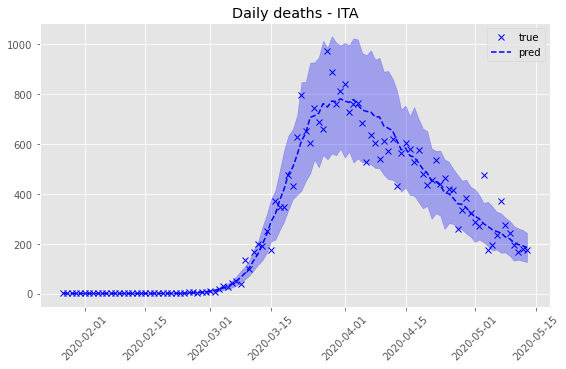

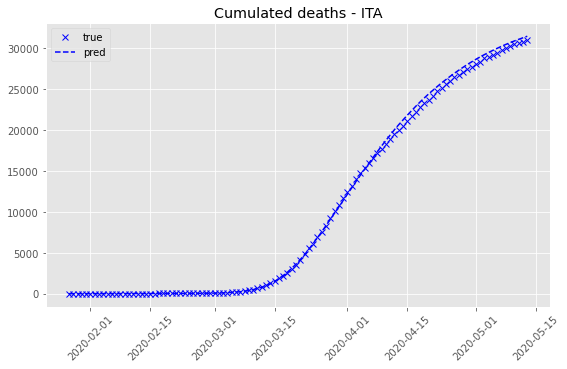

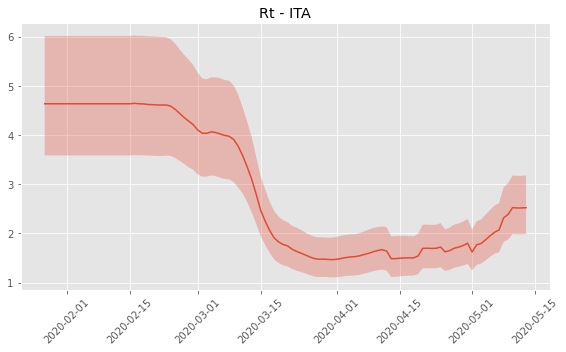

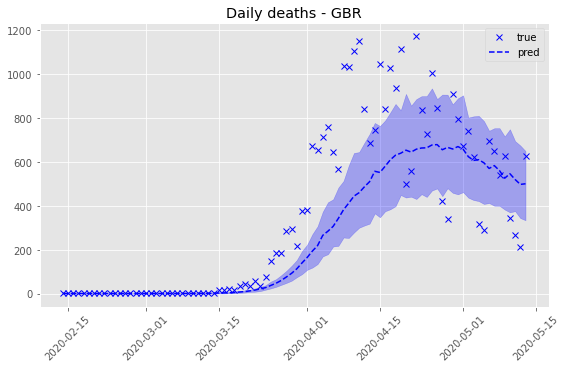

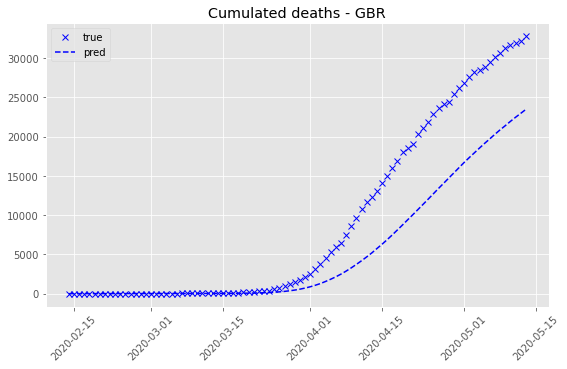

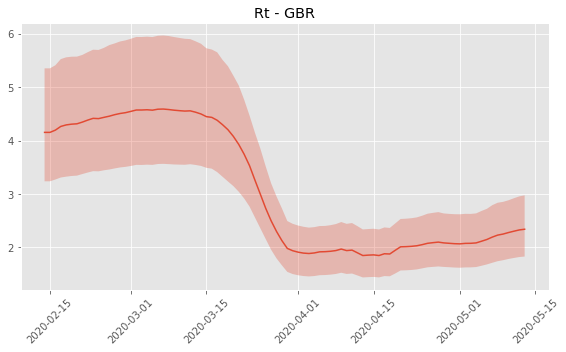

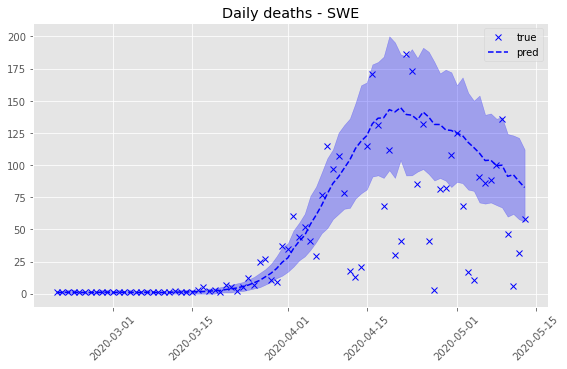

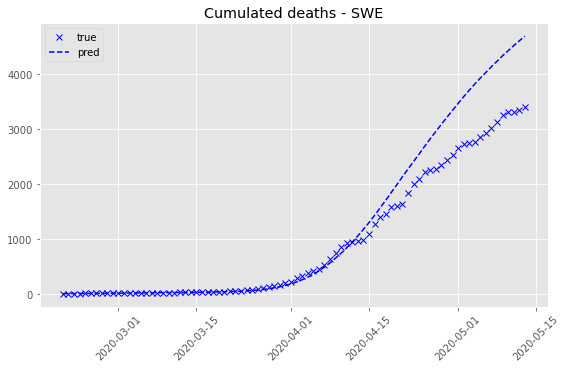

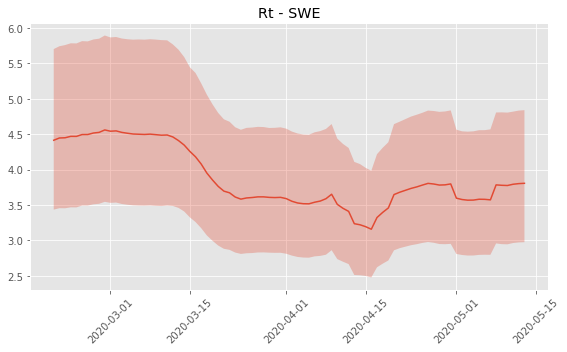

In [73]:
for i, country in enumerate(reorder(all_countries, mask_train, mask_test)):
    mu, pi = compute_mu_pi(y_pred, f'deceased_{i}')
    plot_daily_cumulated(mu, pi, reorder(all_deaths, mask_train, mask_test)[i], reorder(all_times, mask_train, mask_test)[i], 
                         f'deaths - {country}')
    mobility_data = reorder(all_mobilities, mask_train, mask_test)[i]
    times = reorder(all_times, mask_train, mask_test)[i]
    rt_pi = compute_rt_samples(samples, mobility_data, times.shape[0])    
    mu, pi = compute_mu_pi_3(rt_pi)
    
    fig, ax = plt.subplots(figsize=(8, 5))
    plt.plot(times, mu)
    plt.xticks(rotation=45)
    plt.fill_between(times, pi[0], pi[1], alpha=0.3, interpolate=True)
    plt.title(f'Rt - {country}')
    
    plt.tight_layout()
    
#     seirhcd_int = build_my_odeint(mobility_data)
#     seirhcd_int()

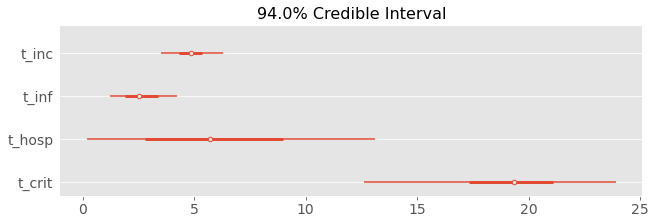

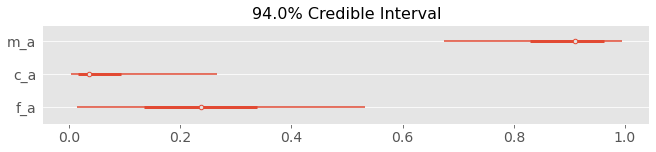

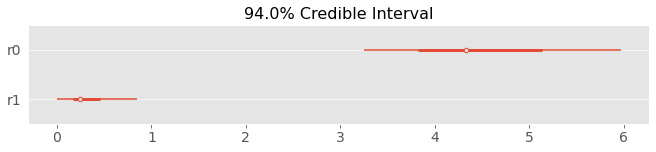

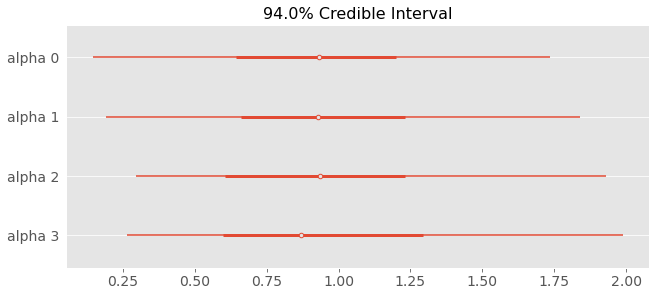

In [35]:
inference_data = az.from_numpyro(mcmc_multi)
plot_forest(inference_data)

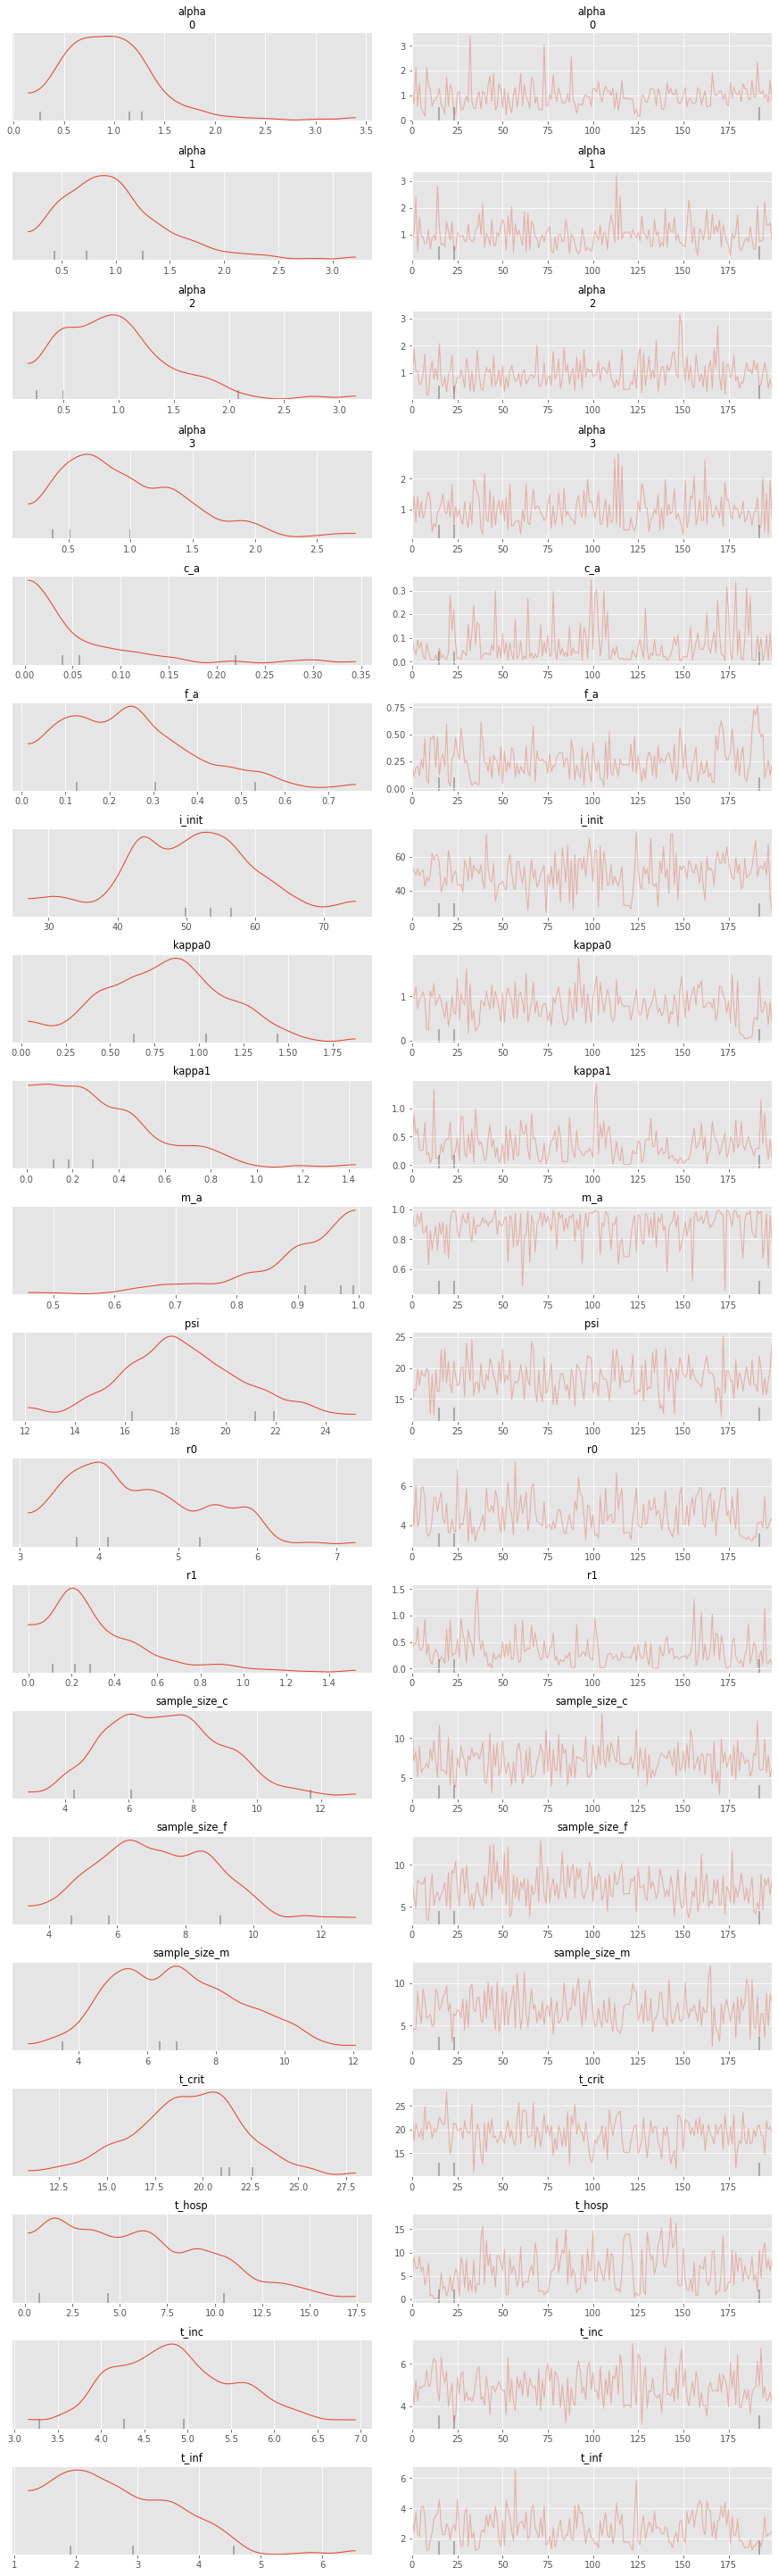

In [27]:
az.plot_trace(inference_data) ;

### Single country

#### D only

In [66]:
def single_infer_and_plot(i, 
                           country,
                           pop_country,
                           mobility_data,
                           daily_deaths_true, 
                           times
                          ):

    # integrator
    seirhcd_int = build_my_odeint(mobility_data)
    
    mcmc = MCMC(NUTS(model, dense_mass=True),
                500, 500, num_chains=NUM_CHAINS, progress_bar=True)
    mcmc.run(PRNGKey(0), 
             seirhcd_int, 
             N=daily_deaths_true.shape[0], 
             pop_country = pop_country,
             y=daily_deaths_true, 
             compartments='d',
             nb_mobilities=mobility_data.shape[1]
            )
    mcmc.print_summary()

    predictive = Predictive(model, mcmc.get_samples())
    y_pred = predictive(PRNGKey(2),
                        seirhcd_int, 
                        N=daily_deaths_true.shape[0], 
                        pop_country=pop_country,
                        compartments='d', 
                        nb_mobilities=mobility_data.shape[1])
    mu, pi = compute_mu_pi(y_pred, 'deceased')
    plot_daily_cumulated(mu, pi, daily_deaths_true, times, 
                         f'deaths - {country}')
    return mcmc

running for country Spain


sample: 100%|██████████| 1000/1000 [03:07<00:00,  5.33it/s, 31 steps of size 1.09e-01. acc. prob=0.91] 



                     mean       std    median      5.0%     95.0%     n_eff     r_hat
       alpha[0]      1.01      0.46      0.92      0.34      1.79    651.25      1.00
       alpha[1]      1.00      0.52      0.91      0.26      1.80    568.22      1.00
       alpha[2]      1.00      0.49      0.92      0.33      1.73    535.93      1.00
       alpha[3]      1.08      0.52      1.00      0.26      1.76    560.13      1.00
       alpha[4]      0.97      0.50      0.86      0.25      1.74    441.46      1.00
       alpha[5]      1.06      0.53      0.96      0.32      1.90    331.86      1.00
       alpha[6]      0.99      0.49      0.89      0.29      1.73    306.25      1.00
            c_a      0.04      0.05      0.03      0.00      0.09    242.47      1.00
            f_a      0.33      0.17      0.30      0.05      0.57    294.62      1.00
    i_init_None     44.33     10.25     44.79     26.89     60.06    259.85      1.00
         kappa0      0.50      0.32      0.46      0.

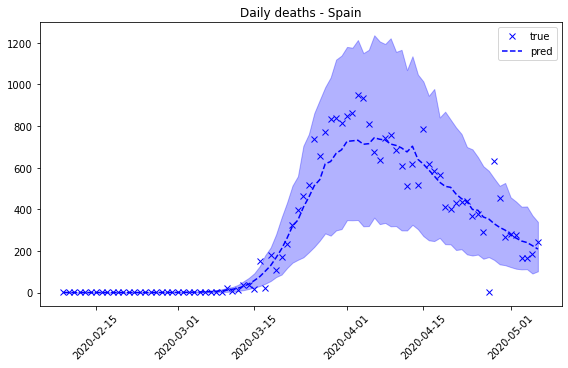

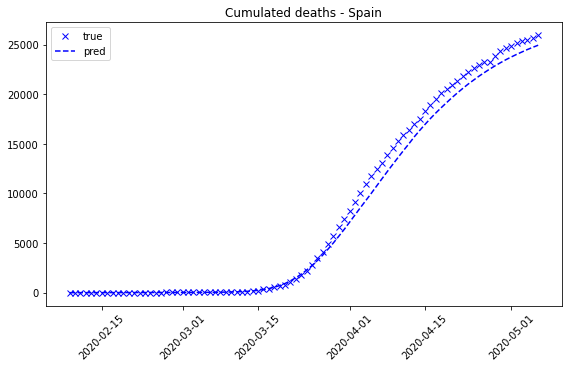

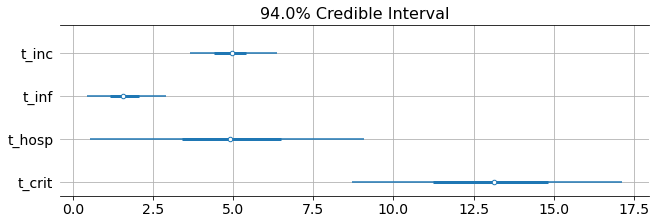

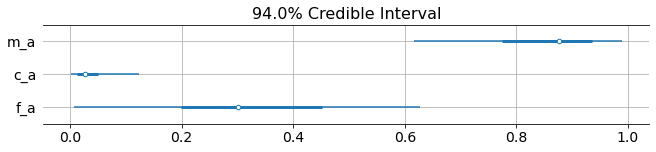

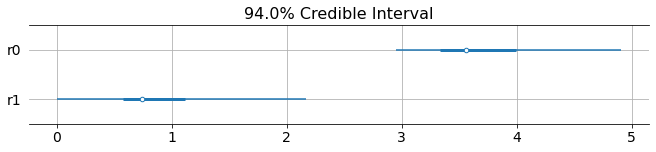

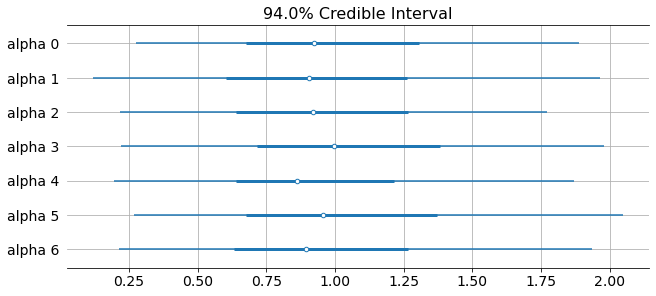

In [67]:
mcmcs_single = dict()
for i, country in enumerate(all_countries):
    print(f"running for country {country}")
    mcmc = single_infer_and_plot(i, 
                           country, 
                           all_populations[i],
                           all_mobilities[i],
                           all_deaths[i], 
                               all_times[i]
                              )
    mcmcs_single[country] = mcmc  

    inference_data = az.from_numpyro(mcmc)
#     plot_forest(inference_data)
    

#### H, C and D

In [ ]:
## Smoothing HCD data
daily_critical = np.hstack((np.array([0.]), np.diff(hosp_indexed['rea'].to_numpy())))
daily_hosp = np.hstack((np.array([0.]), np.diff(hosp_indexed['hosp'].to_numpy())))

raw_data = np.stack([daily_hosp, daily_critical, daily_deaths_true]).T + 1
# data = np.stack([hosp_indexed['hosp'].to_numpy(), hosp_indexed['rea'].to_numpy(), daily_deaths_true + 1]).T

data = pd.DataFrame(raw_data).rolling(10, center=True).mean().fillna(method='bfill').fillna(method='ffill').to_numpy()

df = pd.DataFrame(data)
df.columns = 'h c d'.split()

df_raw = pd.DataFrame(raw_data)
df_raw.columns = 'h c d'.split()

ax = df_raw.plot(marker='x', figsize=(10, 5))
df.plot(ax=ax)

In [ ]:
# # H, C and D inference
# mcmc.run(PRNGKey(0), seirhcd_int, 
#          N=data.shape[0], 
#          y=data, 
#          compartments='hcd')
# mcmc.print_summary()

## some plots

In [48]:
# for i, country in enumerate(all_countries):
#     predictive = Predictive(model, mcmcs_single[country].get_samples())
#     y_pred = predictive(PRNGKey(2), seirhcd_int, N=daily_deaths_true.shape[0], compartments='hcd')

In [71]:
# plot_hcd_results(mu, pi, data, daily_deaths_true, times)
# plot_hcd_results(mu, pi, np.zeros(data.shape), daily_deaths_true, times)
# data = np.hstack([np.zeros((all_deaths[0].shape[0], 2)), all_deaths[0][:, np.newaxis]])
# plot_hcd_results(mu[:, np.newaxis], 
#                  pi[:, :, np.newaxis], 
#                  data, 
#                  all_times[0])

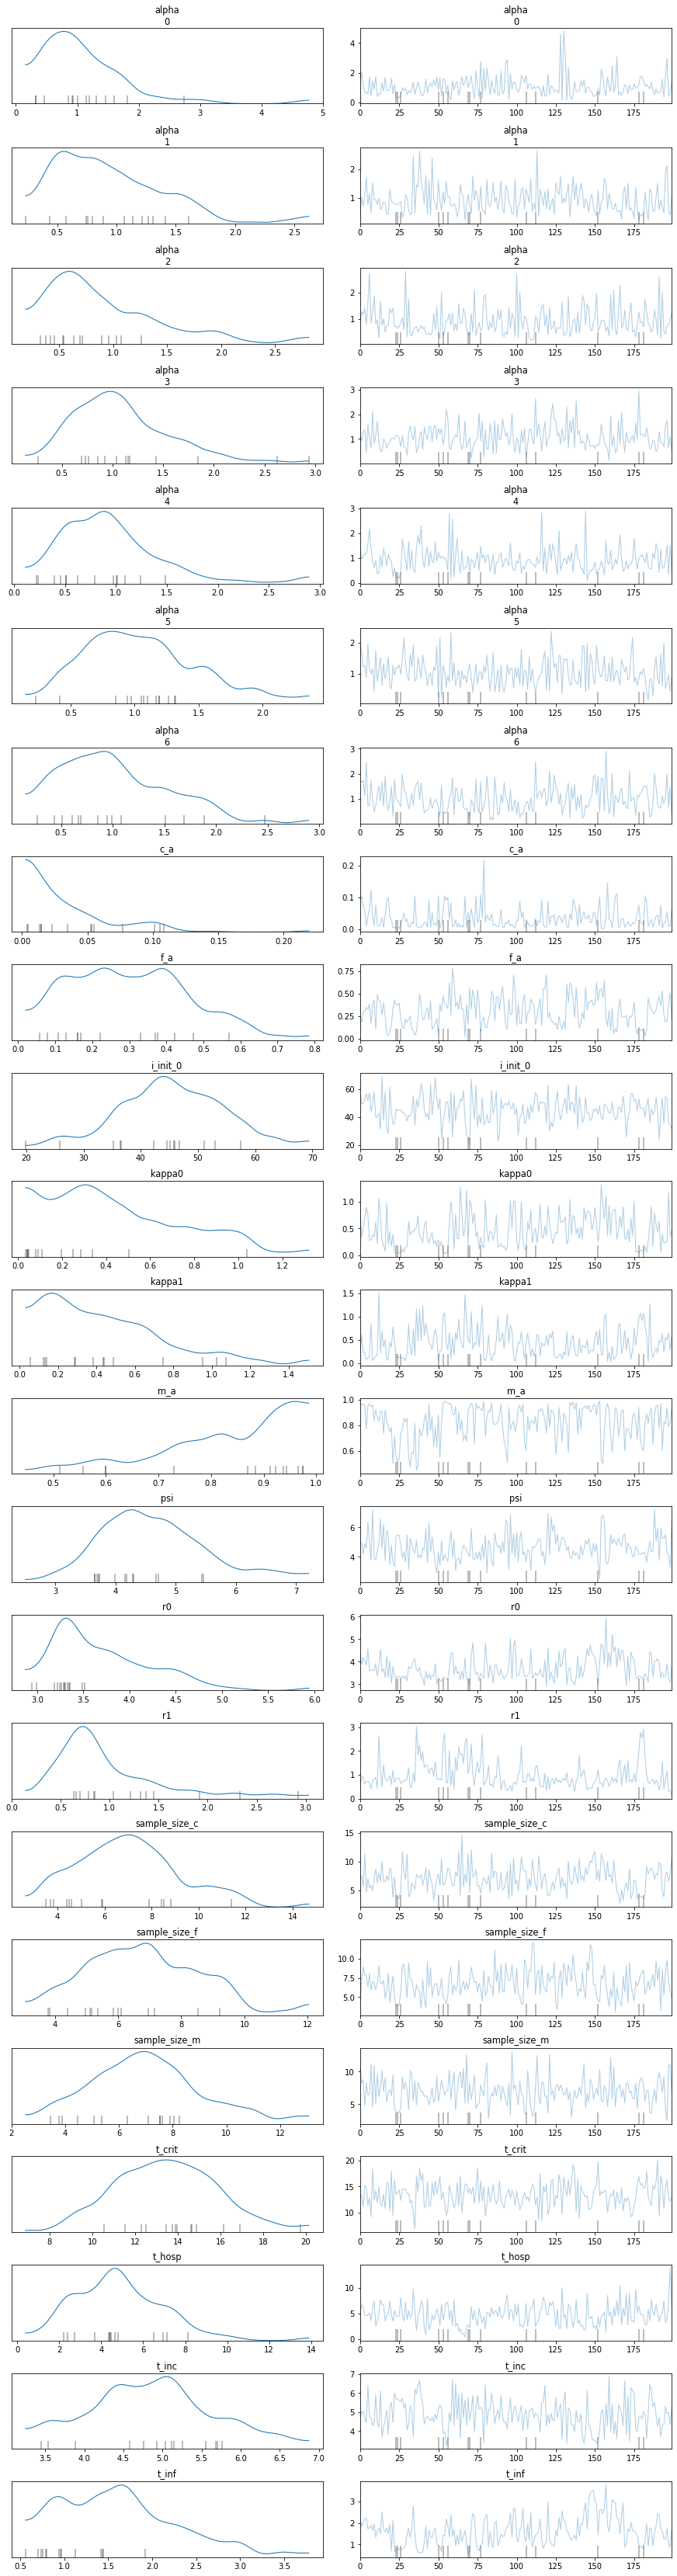

In [54]:
az.plot_trace(inference_data) ;

## Running the compartment model

In [52]:
%load_ext line_profiler

The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler


In [47]:
%%write_eval compartments.py

def run_sim_samples(integrator, samples, N, pop_country):
    ts = np.arange(float(N))
    res = []
    corr_samples = {**samples, 
                    **{'alpha': samples['alpha'] / samples['alpha'].sum(axis=1)[:, np.newaxis]},
                    **{'i_init': samples['i_init'] / pop_country}
                   }
    nb_samples = corr_samples['r0'].shape[0]
    z_init = np.array([1. - corr_samples['i_init'], 
                       np.zeros(nb_samples), 
                       corr_samples['i_init'], 
                       np.zeros(nb_samples), 
                       np.zeros(nb_samples), 
                       np.zeros(nb_samples), 
                       np.zeros(nb_samples)
                      ]).T

    arg_names = 'r0, r1, t_inc, t_inf, t_hosp, t_crit, m_a, c_a, f_a'.split(', ')
    args = (corr_samples[name] for name in arg_names)
    alpha = corr_samples['alpha']
    res = vmap(integrator)(z_init, 
                           np.repeat(ts[np.newaxis, :], nb_samples, axis=0), 
                           *args, 
                           *[alpha[:, i] for i in range(alpha.shape[1])])
    
    return res

def plot_compartment(pred_data, true_data, pop_country, times):
    pi = np.percentile(pred_data, (10., 90.), 0)
    
    plt.plot(onp.asarray(times), np.mean(pred_data, axis=0) * pop_country, label='pred')
#     plt.plot(times, true_data, label='true')
    plt.fill_between(onp.asarray(times), pi[0, :] * pop_country, pi[1, :] * pop_country, interpolate=True, alpha=0.3)
    plt.legend()

def plot_hcd(res, pop_country, times, title=None):
    for i, name in enumerate(['hospitalized', 'critical', 'deceased' ], start=5):
        plt.subplots()
#         plot_compartment(res[:, :, -i], hosp_indexed[name].to_numpy(), pop_country)
        plot_compartment(res[:, :, i], np.zeros(res.shape[1]), pop_country, times)
        plt.title(name + ' - ' + title)
    
def plot_seir(res, pop_country, times, title=None):
    for i, name in enumerate(['susceptible', 'exposed', 'infected', 'recovered']):
        plt.subplots()
        plot_compartment(res[:, :, i], np.zeros(res.shape[1]), pop_country, times)
        plt.title(name + ' - ' + title)

Overwriting compartments.py


In [167]:
samples = mcmc_multi.get_samples()
# pred = Predictive(model, mcmc.get_samples())(PRNGKey(2), data.shape[0])

### True mobility

In [67]:
for i, country_code in enumerate(reorder(all_countries, mask_train, mask_test)):
    all_times_reordered = reorder(all_times, mask_train, mask_test)
    seirhcd_int = build_my_odeint(reorder(all_mobilities, mask_train, mask_test)[i])
    break
    
res=run_sim_samples(seirhcd_int, samples, all_times_reordered[i].shape[0], reorder(all_populations, mask_train, mask_test)[i])
#     plot_seir(res, reorder(all_populations, mask_train, mask_test)[i], all_times_reordered[i], title=country_code)
#     plot_hcd(res, reorder(all_populations, mask_train, mask_test)[i], all_times_reordered[i], title=country_code)

In [69]:
%timeit res=run_sim_samples(seirhcd_int, samples, all_times_reordered[i].shape[0], reorder(all_populations, mask_train, mask_test)[i])

121 ms ± 8.94 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


### Fake mobility

In [ ]:
mobility_fake = np.zeros(mobility_data.shape)
seirhcd_int_zeros = build_my_odeint(mobility_fake)
res_fake = run_sim_samples(seirhcd_int_zeros, samples)

In [ ]:
plot_seir(res_fake)
plot_hcd(res_fake, hosp_indexed)

## Running SEIR-HCD model with prior means

### True mobility

In [37]:
country

'SWE'

In [47]:
args

Params(r0=3.28, r1=0.2, t_inc=5.6, t_inf=7.9, t_hosp=4.0, t_crit=14.0, m_a=0.8, c_a=0.1, f_a=0.35)

In [48]:
alpha

array([0.25, 0.25, 0.25, 0.25])

In [46]:
alpha = np.asarray(np.ones(mobility_data.shape[1]) / mobility_data.shape[1])
args = PRIOR_MEANS

i_init = 50
i_init /= populations_country.loc[country]
z_init = np.array([1. - i_init, 0., i_init, 0., 0., 0., 0.])
ts = np.arange(float(mobility_data.shape[0]))

seirhcd_int = build_my_odeint(mobility_data)
sim_res = seirhcd_int(z_init, ts, *args, *alpha)

df_res = pd.DataFrame(sim_res) * pop_country
df_res.columns = 's e i r h c d'.split()

# fig, ax = plt.subplots()
df_res = df_res.eval('total_cases = i + r + h + c + d').set_index(times)
for col in df_res.columns:
    plt.subplots()
    df_res[col].plot(figsize=(8, 5))
    plt.title(col)

ValueError: setting an array element with a sequence.

### Fake mobility

In [ ]:
fake_mobility = np.zeros(mobility_data.shape)
seirhcd_int_fake = build_my_odeint(fake_mobility)
sim_res = seirhcd_int_fake(z_init, ts, *args, *alpha)

df_res = pd.DataFrame(sim_res) * pop_country
df_res.columns = 's e i r h c d'.split()

# fig, ax = plt.subplots()
df_res = df_res.eval('total_cases = i + r + h + c + d').set_index(times)
for col in df_res.columns:
    plt.subplots()
    df_res[col].plot(figsize=(8, 5))
    plt.title(col)

## Debug

In [ ]:
params = PRIOR_MEANS
N = data.shape[0]

i_init = 50 / pop_country
z_init = np.array([1 - i_init, 0, i_init, 0, 0, 0, 0])
ts = np.arange(float(N))
z = seirhcd_int(z_init, ts, *params)

total_deaths = z[:, -1] * pop_country
daily_deaths = np.hstack((np.array([0.]), np.diff(z[:, -1] * pop_country)))
daily_deaths += 1

daily_critical = np.hstack((np.array([0]), np.diff(z[:, -2] * pop_country))) 
#     daily_critical += BUMP_CRITICAL
daily_critical += 1

daily_hosp = np.hstack((np.array([0]), np.diff(z[:, -3] * pop_country))) 
#     daily_hosp += BUMP_HOSP
daily_hosp += 1

critical = z[:, -2] * pop_country
hosp = z[:, -3] * pop_country

hosp_m1 = np.hstack(([0.],  hosp[:-1]))
critical_m1 = np.hstack(([0.],  critical[:-1]))

bump_hosp = np.min(np.stack([hosp_m1, BUMP_HOSP * np.ones(N)]), axis=0)
bump_critical = np.min(np.stack([critical_m1, BUMP_CRITICAL * np.ones(N)]), axis=0)

nb_samples = 100
samples = dict()
for i in range(nb_samples):
    psi = dist.TruncatedNormal(scale=5.).sample(PRNGKey(5*i))
    psi_h = dist.TruncatedNormal(scale=5.).sample(PRNGKey(5*i+1))
    psi_c = dist.TruncatedNormal(scale=5.).sample(PRNGKey(5*i+2))
    target_dist = dist.GammaPoisson(
                       np.array([psi_h, psi_c, psi]),
                       rate=np.stack([psi_h / (daily_hosp + bump_hosp), 
                                      psi_c / (daily_critical + bump_critical), 
                                      psi / daily_deaths]
                                    ).T
    )

    reloc = dist.transforms.AffineTransform(
        loc=np.stack([
            - bump_hosp,
            - bump_critical,
            np.zeros(N)]
        ).T,
        scale=1.)

    reloc_target_dist = dist.TransformedDistribution(target_dist, [reloc])

    samples[i] = target_dist.sample(PRNGKey(5*i+3), (nb_samples,))

In [ ]:
for i in 1, 2, 3:
    mu = np.mean(samples[i], axis=0)
    pi = np.percentile(samples[i].astype(float), (10., 90.), axis=0)
    # df = pd.DataFrame(mu).set_index(times)
    # df.columns = 'h c d'.split()
    # # df.eval('cumul_d = d.cumsum()').plot()
    # df.plot()

    plot_hcd_results(mu, pi, data, daily_deaths_true, times)

# Misc

In [ ]:
beta = dist.Beta(*reparametrize_beta(0.3, 10))
beta_samples = beta.sample(PRNGKey(0), (1000,))
pd.DataFrame({'samples': beta_samples}).samples.astype(float).plot.kde()
plt.xlim(0, 1)

## IHME dataset

In [ ]:
df = pd.read_csv('../input/ihme-covid19/2020_05_04/Hospitalization_all_locs.csv')

In [ ]:
df.set_index(['location_name', 'date']).loc["United States of America"]

In [ ]:
df.location_name.value_counts().sort_index().index.map(print)